### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Preprocessing

In [2]:
def read_image_file(path):
    with open(path, "rb") as f:
        data = f.read()
        num_cols = int(data[3:5])
        num_rows = int(data[6:9])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=14)
        return np.array(parsed).reshape(num_rows, num_cols)

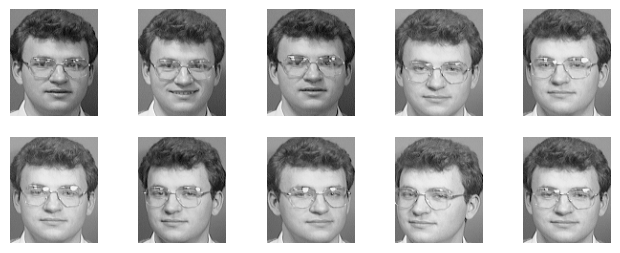

In [3]:
# visaulize images of id = 6
id = 5
plt.figure(figsize=(8,8))
for j in range(10):
    img = read_image_file(f"faces/s{id+1}/{j+1}.pgm")
    plt.subplot(5,5,(j+1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')


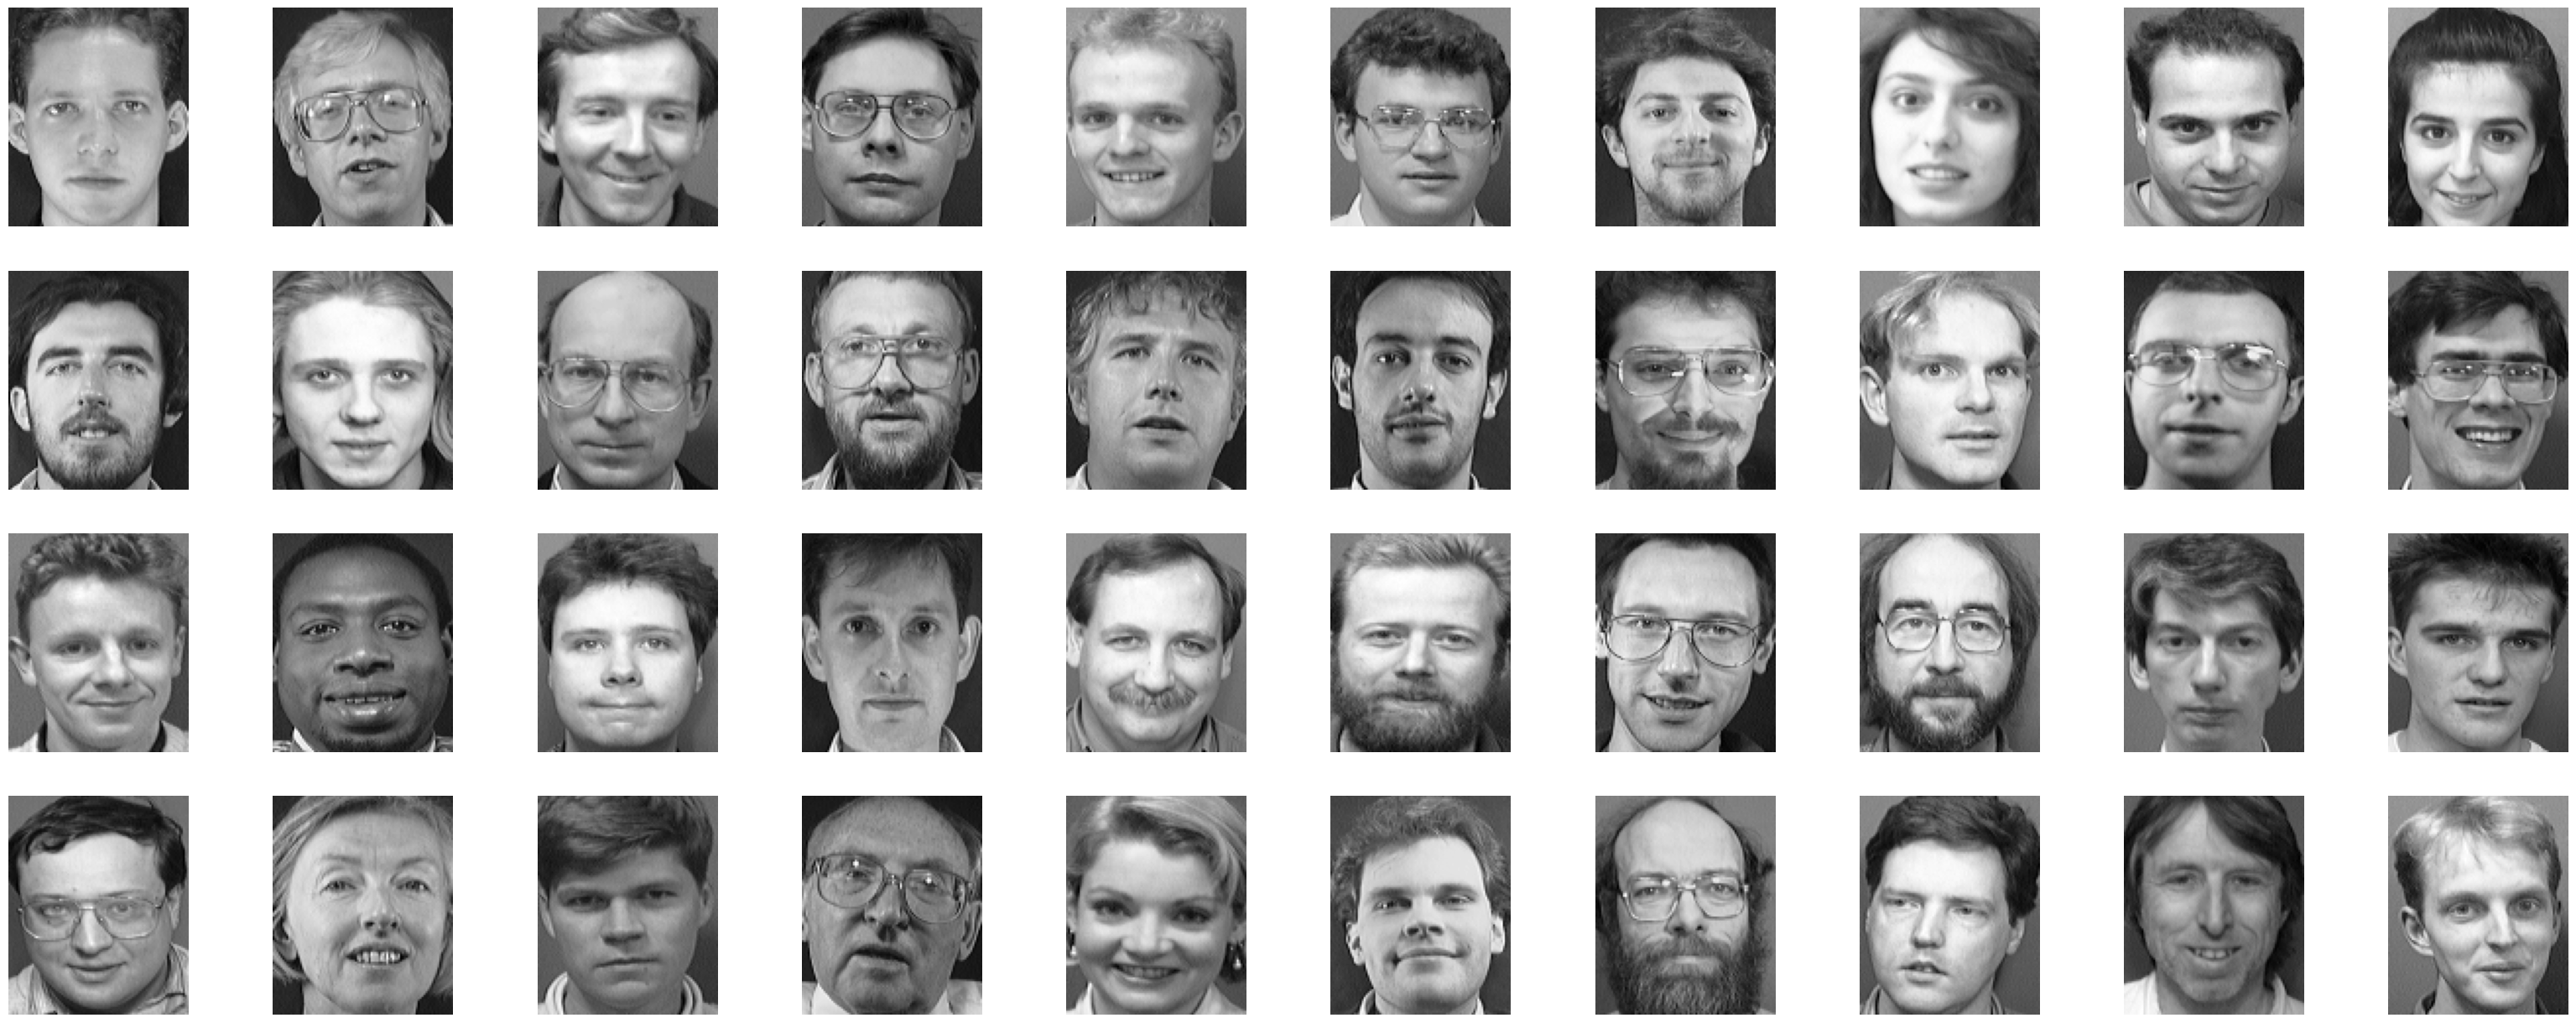

In [4]:
# visaulize images 1 of all ids 
j = 0
plt.figure(figsize=(40,40))
for id in range(40):
    img = read_image_file(f"faces/s{id+1}/{j+1}.pgm")
    plt.subplot(10,10,id+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

In [5]:
# generating Data Matrix
D = np.array([0]*92*112, dtype=int) # int or float ??
y = np.array([], dtype=int)

for i in range(40):
    for j in range(10):
        img = read_image_file(f"faces/s{i+1}/{j+1}.pgm")
        img = img.reshape(-1)
        D = np.vstack((D, img))
        y = np.append(y,i+1)
D = np.delete(D, 0, axis=0)

# shape of Data Matrix and label vector
print(D.shape, y.shape)

(400, 10304) (400,)


In [6]:
# splitting dataset into training and testing sets
odd_rows = np.array([i % 2 != 0 for i in range(400)]) 

# odds rows for taining set
D_train = D[odd_rows]
y_train = y[odd_rows]

# even rows for testing set
D_test = D[~ odd_rows]
y_test = y[~ odd_rows]

# shapes of resulting dataset
print(D_train.shape, y_train.shape)
print(D_test.shape, y_test.shape)


(200, 10304) (200,)
(200, 10304) (200,)


### PCA Implementation

In [7]:
class PCA():
    def __init__(self, alpha):
        self.alpha = alpha
        pass
    def project(D):
        pass
    def eigen_values():
        pass
    def eigen_vectors():
        pass